In [1]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.ensemble import GradientBoostingRegressor

from statsmodels.formula.api import ols

from scipy import stats

In [2]:
df_meta = pd.read_csv('/Users/evanjays/Desktop/Programming/Flatiron/CAPSTONE/data_big/ashrae-energy-prediction/building_metadata.csv')
df = pd.read_csv('/Users/evanjays/Desktop/Programming/Flatiron/CAPSTONE/data_big/ashrae-energy-prediction/train.csv')
df_weather = pd.read_csv('/Users/evanjays/Desktop/Programming/Flatiron/CAPSTONE/data_big/ashrae-energy-prediction/weather_train.csv')
df_sample = pd.read_csv('/Users/evanjays/Desktop/Programming/Flatiron/CAPSTONE/data_big/ashrae-energy-prediction/sample_submission.csv')

## Data Exploration

### Weather Data

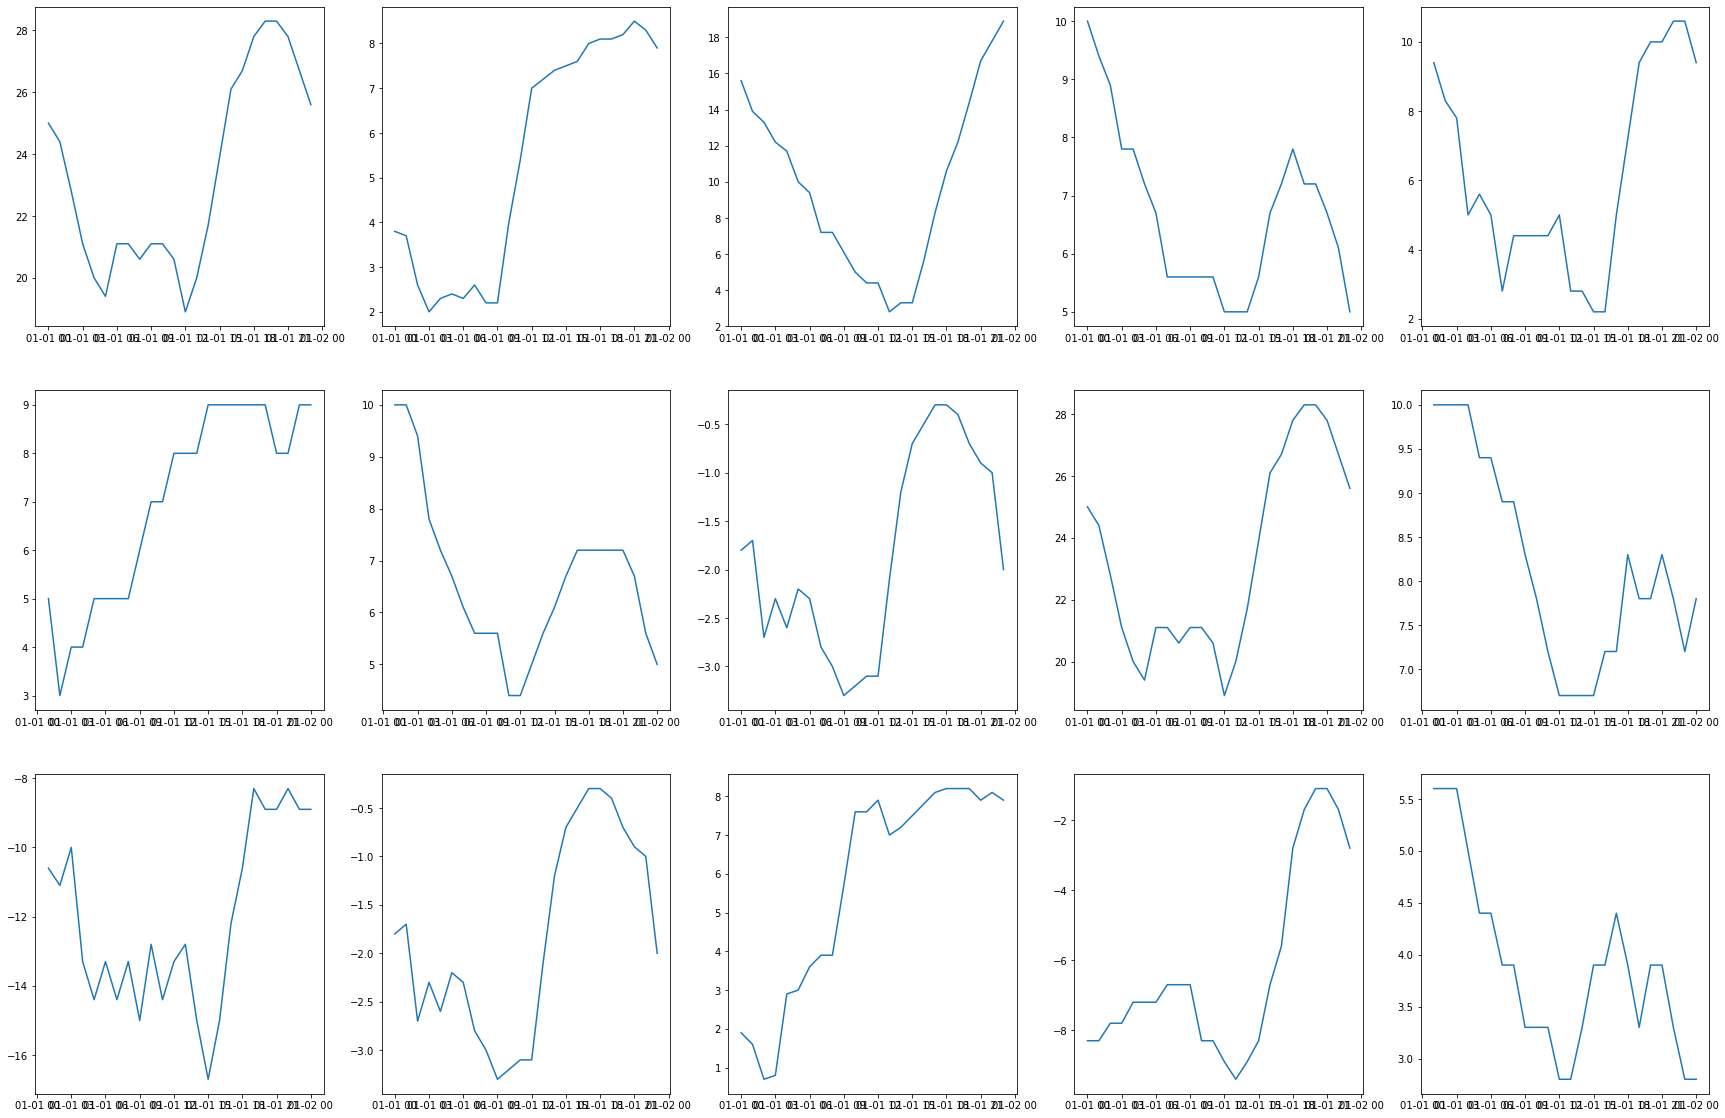

In [3]:
df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])
df_weather_time = df_weather.copy(deep=True)
df_weather_time.set_index('timestamp',drop=True,inplace=True)

fig, ax = plt.subplots(ncols=5,nrows=3,figsize=(30,20))
count = 0
for i in range(3):
    for j in range(5):
        ax[i,j].plot(df_weather_time[df_weather_time['site_id'] == count]['air_temperature'][:24])
        count += 1

#### Time Shifting the Weather Data to each sites local time

In [4]:
def time_shift(dataframe,site):
    time_shift_dict = {0:-3,1:-5,2:-7,3:-9,4:-7,5:0,6:-12,7:-3,8:-4,9:-10,10:-3,11:-3,12:-16,13:-5,14:-12,15:-5}
    df_temp_1 = pd.DataFrame()
    df_temp_1 = dataframe.shift(periods=time_shift_dict[site])
    df_temp_1['site_id'].ffill(inplace=True)
    df_temp_1['air_temperature'].ffill(inplace=True)
    return df_temp_1

# Create Weather input variables sampled bi-monthly
site_weather_list = []

df_weekday = pd.DataFrame([1,0,0,1,1,1,1] * 52 + [1,0],columns=['is_weekday'])  #DAILY
# df_weekday = pd.DataFrame([1,1,0,0,0,0,1,1,1,1,1,1,1,1] * 52 + [1,1,0,0],columns=['is_weekday'])   #12H

for i in range(16):
    df_temp = pd.DataFrame()
    df_temp = df_weather_time[df_weather_time['site_id'] == i]
    df_temp = time_shift(df_temp,i).resample('D').mean()
    df_temp.reset_index(inplace=True)
    df_temp = pd.concat([df_temp,df_weekday],axis=1)
    df_temp.site_id.ffill(inplace=True)
    df_temp.air_temperature.ffill(inplace=True)
    site_weather_list.append(df_temp)

df_weather_daily = pd.DataFrame()
for dataframe in site_weather_list:
    dataframe.reset_index(inplace=True,drop=True)
    df_weather_daily = pd.concat([df_weather_daily,dataframe])

In [5]:
df_weather_daily

,timestamp,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,is_weekday
0,2016-01-01,0.0,23.266667,4.571429,19.787500,-0.166667,1018.718182,158.750000,2.225000,1
1,2016-01-02,0.0,18.733333,6.400000,14.612500,-0.041667,1018.941667,130.833333,4.154167,0
2,2016-01-03,0.0,14.154167,8.000000,12.175000,1.125000,1016.912500,315.833333,4.891667,0
3,2016-01-04,0.0,12.825000,1.625000,3.687500,0.041667,1016.060870,280.416667,4.454167,1
4,2016-01-05,0.0,14.433333,2.000000,7.666667,0.000000,1023.133333,143.333333,6.287500,1
...,...,...,...,...,...,...,...,...,...,...
361,2016-12-27,15.0,3.575000,3.500000,0.016667,2.600000,1012.237500,247.083333,5.229167,1
362,2016-12-28,15.0,-2.208696,2.000000,-5.543478,1.500000,1019.230435,221.304348,3.552174,1
363,2016-12-29,15.0,-0.445833,0.000000,-3.220833,-0.166667,1005.408333,193.750000,4.912500,1
364,2016-12-30,15.0,-1.895833,NaN,-5.208333,-1.000000,1005.308333,273.333333,6.412500,1


### Building Metadata

### Building Energy Usage Data

In [6]:
meter_data_list = []
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df[df['meter'] == 0]
for i in df['building_id'].unique():
    df_temp = pd.DataFrame()
    df_temp = df[df['building_id'] == i].copy(deep=True)
    df_temp.set_index('timestamp',inplace=True)
    df_temp = df_temp.groupby('building_id').resample('D').sum()
    df_temp.building_id.ffill(inplace=True)
    meter_data_list.append(df_temp)

df_meter_daily = pd.DataFrame()
for dataframe in meter_data_list:
    dataframe.drop(['building_id'],inplace=True,axis=1)
    dataframe.reset_index(inplace=True) 
    df_meter_daily = pd.concat([df_meter_daily,dataframe])

df_meter_daily.drop(['meter'],axis=1,inplace=True)

### Merging the three datasets

In [7]:
df_meta_weather = df_meta.merge(df_weather_daily,how='right',on='site_id')
df_final = df_meter_daily.merge(df_meta_weather,how='left',on=['building_id','timestamp'])

## Train/Test Split

In [8]:
test_df = pd.DataFrame()
train_df = pd.DataFrame()
for i in range(1449):
    if i % 5 == 0:
        test_df = pd.concat([test_df,df_final[df_final['building_id'] == i]])
    else:
        train_df = pd.concat([train_df,df_final[df_final['building_id'] == i]])

## Preprocessing

### Dropping Outliers

In [9]:
train_df = train_df[(np.abs(stats.zscore(train_df['meter_reading'])) < 3)]
train_df = train_df[(np.abs(stats.zscore(train_df['air_temperature'])) < 3)]

# train_df.drop(train_df[(train_df['site_id'] == 0) & (train_df['timestamp']<'2016-06-01')].index,inplace=True)
# train_df_mod.drop(train_df_mod[train_df_mod['meter_reading'] == 0].index,inplace=True)

### Identifying and dropping bad meter readings

In [10]:
def remove_streaks(dataframe,column_name):
    df_mod_x = pd.DataFrame()
    for i in range(1449):
        if i % 5 == 0:
            continue
        normal_df = pd.DataFrame()
        normal_df = dataframe[dataframe.building_id==i]
        still_streaking = True
        while still_streaking == True:
            groups = normal_df.groupby((normal_df[column_name] != normal_df[column_name].shift()).cumsum())
            last = groups.last()
            max_duration = (last['timestamp'] - groups.first().timestamp).nlargest(1)
            try:
                duration = int(str(max_duration.iat[0]).split()[0])
            except:
                duration = 0
            if duration > 5:
                index_val = max_duration.index[0] - 1
                normal_df = normal_df.drop(normal_df.index[index_val:index_val+duration])
            else:
                normal_df.reset_index(inplace=True,drop=True)
                df_mod_x = pd.concat([df_mod_x,normal_df.copy(deep=True)])
                still_streaking = False
    return df_mod_x

train_df_mod = remove_streaks(train_df,'meter_reading')

In [11]:
# Taking log of target to keep from predicting negative values for energy usage
y_train = train_df_mod['meter_reading'].copy(deep=True).map(np.log1p)
X_train = train_df_mod.drop(['meter_reading','timestamp','building_id'],axis=1)

y_test = test_df['meter_reading'].copy(deep=True).map(np.log1p)
X_test = test_df.drop(['meter_reading','timestamp','building_id'],axis=1)

### Imputing Missing Values

In [12]:
use_dict = {}

for use in X_train['primary_use'].unique():
    if X_train[X_train['primary_use'] == use]['floor_count'].isna().sum() == X_train[X_train['primary_use'] == use]['floor_count'].shape[0]:
        use_dict[use] = 1
    else:
        use_dict[use] = round(X_train[X_train['primary_use'] == use]['floor_count'].median())

def get_num_floors(num_floors):
    if num_floors > 0:
        return num_floors
    else:
        return use_dict[use]

def impute_num_floors(dataframe):
    metadata_list = []
    for idx,use in enumerate(dataframe['primary_use'].unique()):
        df_temp = pd.DataFrame()
        df_temp = dataframe[dataframe['primary_use'] == use].copy(deep=True)
        df_temp['floor_count'] = df_temp['floor_count'].map(get_num_floors)
        metadata_list.append(df_temp.copy(deep=True))

    df_imputed = pd.DataFrame()
    for dataframe in metadata_list:
        df_imputed = pd.concat([df_imputed,dataframe])

    df_imputed.drop(['year_built'],inplace=True,axis=1)
    return df_imputed

def impute_weather_data(train_dataframe,test_dataframe):
    site_weather_train_list = []
    site_weather_test_list = []
    si = SimpleImputer()
    for site in range(16):
        df_temp_train = pd.DataFrame()
        df_temp_test = pd.DataFrame()

        df_temp_train = train_dataframe[train_dataframe['site_id'] == site].copy(deep=True)
        df_temp_test = test_dataframe[test_dataframe['site_id'] == site].copy(deep=True)

        # df_temp_train['dew_temperature'] = si.fit_transform(df_temp_train[['dew_temperature']])
        # df_temp_test['dew_temperature'] = si.transform(df_temp_test[['dew_temperature']])

        # df_temp_train['wind_direction'] = si.fit_transform(df_temp_train[['wind_direction']])
        # df_temp_test['wind_direction'] = si.transform(df_temp_test[['wind_direction']])

        # df_temp_train['wind_speed'] = si.fit_transform(df_temp_train[['wind_speed']])
        # df_temp_test['wind_speed'] = si.transform(df_temp_test[['wind_speed']])

        df_temp_train.reset_index(inplace=True,drop=True)
        df_temp_test.reset_index(inplace=True,drop=True)
        site_weather_train_list.append(df_temp_train)
        site_weather_test_list.append(df_temp_test)

    df_weather_train = pd.DataFrame()
    df_weather_test = pd.DataFrame()
    for dataframe in site_weather_train_list:
        dataframe.reset_index(inplace=True,drop=True)
        df_weather_train = pd.concat([df_weather_train,dataframe])
    for dataframe in site_weather_test_list:
        dataframe.reset_index(inplace=True,drop=True)
        df_weather_test = pd.concat([df_weather_test,dataframe])

    ####################

    # df_weather_train['dew_temperature'] = si.fit_transform(df_weather_train[['dew_temperature']])
    # df_weather_test['dew_temperature'] = si.transform(df_weather_test[['dew_temperature']])

    # df_weather_train['wind_direction'] = si.fit_transform(df_weather_train[['wind_direction']])
    # df_weather_test['wind_direction'] = si.transform(df_weather_test[['wind_direction']])

    # df_weather_train['wind_speed'] = si.fit_transform(df_weather_train[['wind_speed']])
    # df_weather_test['wind_speed'] = si.transform(df_weather_test[['wind_speed']])

    ###############

    # df_weather_train['cloud_coverage'] = si.fit_transform(df_weather_train[['cloud_coverage']])
    # df_weather_test['cloud_coverage'] = si.transform(df_weather_test[['cloud_coverage']])

    # df_weather_train['sea_level_pressure'] = si.fit_transform(df_weather_train[['sea_level_pressure']])
    # df_weather_test['sea_level_pressure'] = si.fit_transform(df_weather_test[['sea_level_pressure']])

    # df_weather_train['precip_depth_1_hr'] = si.fit_transform(df_weather_train[['precip_depth_1_hr']])
    # df_weather_test['precip_depth_1_hr'] = si.fit_transform(df_weather_test[['precip_depth_1_hr']])


    ################

    df_weather_train['cloud_coverage'] = df_weather_train['cloud_coverage'].interpolate()
    df_weather_train['dew_temperature'] = df_weather_train['dew_temperature'].interpolate()
    df_weather_train['sea_level_pressure'] = df_weather_train['sea_level_pressure'].interpolate()
    df_weather_train['precip_depth_1_hr'] = df_weather_train['precip_depth_1_hr'].interpolate()
    df_weather_train['wind_direction'] = df_weather_train['wind_direction'].interpolate()
    df_weather_train['wind_speed'] = df_weather_train['wind_speed'].interpolate()

    df_weather_test['cloud_coverage'] = df_weather_test['cloud_coverage'].interpolate()
    df_weather_test['dew_temperature'] = df_weather_test['dew_temperature'].interpolate()
    df_weather_test['sea_level_pressure'] = df_weather_test['sea_level_pressure'].interpolate()
    df_weather_test['precip_depth_1_hr'] = df_weather_test['precip_depth_1_hr'].interpolate()
    df_weather_test['wind_direction'] = df_weather_test['wind_direction'].interpolate()
    df_weather_test['wind_speed'] = df_weather_test['wind_speed'].interpolate()

    return df_weather_train, df_weather_test

X_train_imputed,X_test_imputed = impute_weather_data(impute_num_floors(X_train),impute_num_floors(X_test))

### One Hot Encoding

In [13]:
ohe = OneHotEncoder(drop='first')

ohe_train_array = ohe.fit_transform(X_train_imputed[['primary_use']])
ohe_train_df = pd.DataFrame(ohe_train_array.todense(),columns=[name[3:] for name in ohe.get_feature_names()])

ohe_test_array = ohe.transform(X_test_imputed[['primary_use']])
ohe_test_df = pd.DataFrame(ohe_test_array.todense(),columns=[name[3:] for name in ohe.get_feature_names()])

X_train_imputed.reset_index(inplace=True,drop=True)
X_train_ohe = pd.concat([X_train_imputed,ohe_train_df],axis=1)
X_train_ohe.drop(['primary_use'],axis=1,inplace=True)

X_test_imputed.reset_index(inplace=True,drop=True)
X_test_ohe = pd.concat([X_test_imputed,ohe_test_df],axis=1)
X_test_ohe.drop(['primary_use'],axis=1,inplace=True)

In [14]:
ohe_train_array = ohe.fit_transform(X_train_ohe[['site_id']])
ohe_train_df = pd.DataFrame(ohe_train_array.todense(),columns=['site_'+name[3:] for name in ohe.get_feature_names()])

ohe_test_array = ohe.transform(X_test_ohe[['site_id']])
ohe_test_df = pd.DataFrame(ohe_test_array.todense(),columns=['site_'+name[3:] for name in ohe.get_feature_names()])

X_train_ohe.reset_index(inplace=True,drop=True)
X_train_ohe = pd.concat([X_train_ohe,ohe_train_df],axis=1)
X_train_ohe.drop(['site_id'],axis=1,inplace=True)

X_test_ohe.reset_index(inplace=True,drop=True)
X_test_ohe = pd.concat([X_test_ohe,ohe_test_df],axis=1)
X_test_ohe.drop(['site_id'],axis=1,inplace=True)

### Standard Scaling

In [15]:
column_names = [x.replace(' ','_').replace('/','_') for x in X_train_ohe.columns]

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train_ohe)
X_train_scaled = pd.DataFrame(X_train_scaled,columns=column_names)

X_test_scaled = ss.transform(X_test_ohe)
X_test_scaled = pd.DataFrame(X_test_scaled,columns=column_names)

## Summary

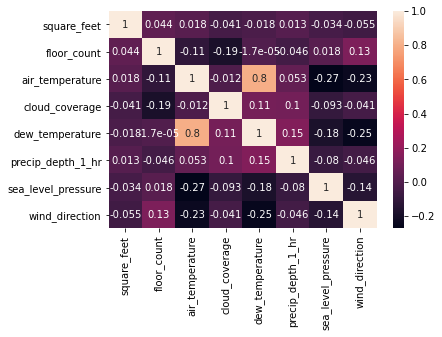

In [16]:
sns.heatmap(X_train_ohe.iloc[:,:8].corr(),annot=True)
plt.show()

### Model Evaluations

In [17]:
X_train_scaled

,square_feet,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,is_weekday,...,site_6,site_7,site_8,site_9,site_10,site_11,site_12,site_13,site_14,site_15
0,-0.842048,-0.3515,0.752203,0.796872,1.224834,-0.323575,0.369772,-0.219383,-0.815680,0.634439,...,-0.165556,-0.058515,-0.205127,-0.320329,-0.149424,-0.061946,-0.171636,-0.339369,-0.279406,-0.289476
1,-0.842048,-0.3515,0.286348,1.568320,0.678286,-0.291060,0.404391,-0.612638,0.358586,-1.576195,...,-0.165556,-0.058515,-0.205127,-0.320329,-0.149424,-0.061946,-0.171636,-0.339369,-0.279406,-0.289476
2,-0.842048,-0.3515,-0.184217,2.243338,0.420854,0.012417,0.090066,1.993408,0.807496,-1.576195,...,-0.165556,-0.058515,-0.205127,-0.320329,-0.149424,-0.061946,-0.171636,-0.339369,-0.279406,-0.289476
3,-0.842048,-0.3515,-0.320805,-0.446186,-0.475538,-0.269383,-0.041854,1.494502,0.541194,0.634439,...,-0.165556,-0.058515,-0.205127,-0.320329,-0.149424,-0.061946,-0.171636,-0.339369,-0.279406,-0.289476
4,-0.842048,-0.3515,-0.155529,-0.287978,-0.055286,-0.280221,1.053693,-0.436554,1.657127,0.634439,...,-0.165556,-0.058515,-0.205127,-0.320329,-0.149424,-0.061946,-0.171636,-0.339369,-0.279406,-0.289476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370417,-0.758457,-0.3515,-1.271354,0.344851,-0.863227,0.396098,-0.634105,1.024945,1.012929,0.634439,...,-0.165556,-0.058515,-0.205127,-0.320329,-0.149424,-0.061946,-0.171636,-0.339369,-0.279406,3.454523
370418,-0.758457,-0.3515,-1.865699,-0.287978,-1.450452,0.109963,0.449122,0.661803,-0.007841,0.634439,...,-0.165556,-0.058515,-0.205127,-0.320329,-0.149424,-0.061946,-0.171636,-0.339369,-0.279406,3.454523
370419,-0.758457,-0.3515,-1.684543,-1.131750,-1.205150,-0.323575,-1.691964,0.273652,0.820177,0.634439,...,-0.165556,-0.058515,-0.205127,-0.320329,-0.149424,-0.061946,-0.171636,-0.339369,-0.279406,3.454523
370420,-0.758457,-0.3515,-1.833548,-0.709864,-1.415056,-0.540344,-1.707454,1.394721,1.733214,0.634439,...,-0.165556,-0.058515,-0.205127,-0.320329,-0.149424,-0.061946,-0.171636,-0.339369,-0.279406,3.454523


In [18]:
lr = LinearRegression()
rfe = RFE(lr,n_features_to_select=30)
rfe.fit(X_train_scaled,y_train)

keep_list = [(k,v) for k,v in zip(X_train_scaled.columns,rfe.support_)]
keep_string = ''
for k,v in keep_list:
    if v:
        keep_string += k + '+'
keep_string = keep_string[:-1]
keep_string

'square_feet+floor_count+air_temperature+is_weekday+Entertainment_public_assembly+Food_sales_and_service+Healthcare+Lodging_residential+Other+Parking+Public_services+Retail+Technology_science+Utility+Warehouse_storage+site_1+site_2+site_3+site_4+site_5+site_6+site_7+site_8+site_9+site_10+site_11+site_12+site_13+site_14+site_15'

In [19]:
X_train_scaled.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
X_train_final = pd.concat([X_train_scaled,y_train],axis=1)

X_test_scaled.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)
X_test_final = pd.concat([X_test_scaled,y_test],axis=1)

In [20]:
formula = f'meter_reading ~ {keep_string}'
model = ols(formula,X_train_final).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          meter_reading   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     2714.
Date:                Tue, 23 Nov 2021   Prob (F-statistic):               0.00
Time:                        21:01:09   Log-Likelihood:            -6.6905e+05
No. Observations:              370422   AIC:                         1.338e+06
Df Residuals:                  370391   BIC:                         1.339e+06
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         7.2147      0.002   2981.018      0.000       7.210       7.219
square_feet                      -0.0228      0.003     -8.622      0.000      -0.028      -0.018
floor_count                       0.0209      0.005      4.508      0.000       0.012       0.030
air_temperature                   0.0115      0.003      4.024      0.000       0.006       0.017
is_weekday                        0.0216      0.002      8.919      0.000       0.017       0.026
Entertainment_public_assembly     0.0189      0.003      7.328      0.000       0.014       0.024
Food_sales_and_service           -0.0120      0.002     -4.926      0.000      -0.017      -0.007
Healthcare                        0.0218      0.002      8.804      0.000       0.017       0.027
Lodging_residential              -0.0316      0.003    -12.199      0.000      -0.037      -0.027
Other                            -0.0746      0.003    -29.554      0.000      -0.080      -0.070
Parking                          -0.0791      0.003    -31.238      0.000      -0.084      -0.074
Public_services                   0.0461      0.003     16.444      0.000       0.041       0.052
Retail                           -0.0455      0.003    -18.149      0.000      -0.050      -0.041
Technology_science               -0.0233      0.002     -9.538      0.000      -0.028      -0.019
Utility                           0.0233      0.002      9.518      0.000       0.018       0.028
Warehouse_storage                 0.0381      0.002     15.594      0.000       0.033       0.043
site_1                           -0.0668      0.004    -16.374      0.000      -0.075      -0.059
site_2                           -0.1859      0.004    -44.349      0.000      -0.194      -0.178
site_3                           -0.5130      0.005    -95.014      0.000      -0.524      -0.502
site_4                           -0.2695      0.005    -57.459      0.000      -0.279      -0.260
site_5                           -0.5900      0.004   -146.676      0.000      -0.598      -0.582
site_6                           -0.0710      0.003    -23.337      0.000      -0.077      -0.065
site_7                            0.1001      0.003     37.186      0.000       0.095       0.105
site_8                           -0.5272      0.003   -153.620      0.000      -0.534      -0.520
site_9                           -0.1137      0.004    -27.776      0.000      -0.122      -0.106
site_10                          -0.1336      0.003    -44.280      0.000      -0.140      -0.128
site_11                           0.0429      0.003     16.917      0.000       0.038       0.048
site_12                          -0.1182      0.003    -37.442      0.000      -0.124      -0.112
site_13                          -0.0787     

In [23]:
y_test_preds = model.predict(X_test_scaled)
np.sqrt(mean_squared_error(np.expm1(y_test),np.expm1(y_test_preds)))
np.sqrt(mean_squared_log_error(np.expm1(y_test),np.expm1(y_test_preds)))

2.253629686470407

In [22]:
gbr = GradientBoostingRegressor()

gbr.fit(X_train_scaled,y_train)
y_test_preds = gbr.predict(X_test_scaled)
# gbr.score(X_test_scaled,y_test)
np.sqrt(mean_squared_log_error(y_test,y_test_preds))

0.5394242401715222